In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from glob import glob
import cartopy.crs as ccrs
import cartopy.feature as cf

from utils.plotter import Plotter
from utils.data_handler import DataHandler

Plotter.change_folder("figs_compar_filters_100")
spin_up_days = 7
start_date = "2014-06-01"
end_date = "2014-08-31"
assimilation_end_date = "2014-08-31"
assimilation_steps = 99

noos_folder = "/home/mverlaan/einf220/fromDavid/gtsm_openDA_david/stochObserver/noos_cmems"
noos_file = lambda station: os.path.join(noos_folder, f"timeseries_{start_date}_{end_date}_{station}_averaged.noos")
locs_file = "/home/mverlaan/einf220/fromDavid/gtsm_openDA_david/stochModel/input_dflowfm/grid_locs_bk.xyn"

labels = ["Simulation", "EnKF"]
av_files = ["~/einf220/fromDavid/saved_results/gtsm/simulation_mdt/gtsm_fine_0000_averaged_his.nc",
            "/home/mverlaan/einf220/fromDavid/saved_results/gtsm/output_enkf/work0/output/full_gtsm_fine_averaged_0000_his.nc"]

In [28]:
rmses_per_exp = []
xs_locs, ys_locs, stations = DataHandler.read_xyn(locs_file)
for i, station in enumerate(stations):
    rmses = []
    ts_avs = []
    ws_avs = []

    # Get observations
    ts_obs, obs = DataHandler.read_noos(noos_file(station))
    observations = [ts_obs[:assimilation_steps], obs[:assimilation_steps]]

    for av_file in av_files:
        # Fix stations
        nc = xr.open_dataset(av_file)

        stations_his = nc.station_name.values.tolist()
        stations_his = np.array([s.decode("utf-8").strip() for s in stations_his])
        nc["station_name"] = ("stations", stations_his)

        # Get model results
        station_data = nc.where(nc.station_name == station).dropna("stations")
        sim = station_data.waterlevel.values.squeeze()
        ts = station_data.time.values.squeeze()

        ts_avs.append(ts)
        ws_avs.append(sim)

        data1 = obs[: assimilation_steps - spin_up_days]
        data2 = sim[spin_up_days:assimilation_steps]
        rmses.append(np.sqrt(((data1 - data2) ** 2).mean()))

        # Plot results
        title_func = lambda s: f"Averaged water level at {s}"

    if i in [34, 32, 30, 28]:
        Plotter.plot_series(
            ts_avs,
            ws_avs,
            station,
            title_func,
            obs_data=observations,
            legends=labels,
        )
    rmses_per_exp.append(rmses)

rmses_per_exp = np.array(rmses_per_exp).T.tolist()

ValueError: operands could not be broadcast together with shapes (49,) (85,) 

In [ ]:
for rmses, label in zip(rmses_per_exp, labels):
    Plotter.hist(
        rmses,
        bins=10,
        path=f"hist_rmses_{label}.pdf",
        xlabel="RMSE $(m)$",
        ylabel="Count",
    )
    plt.show()
    print(np.array(rmses).mean())

In [ ]:
xr.load_dataset(
    "/home/mverlaan/einf220/fromDavid/saved_results/gtsm/kg_backwards/kgStorage_201406020000/kalmanGainStorage.nc"
)

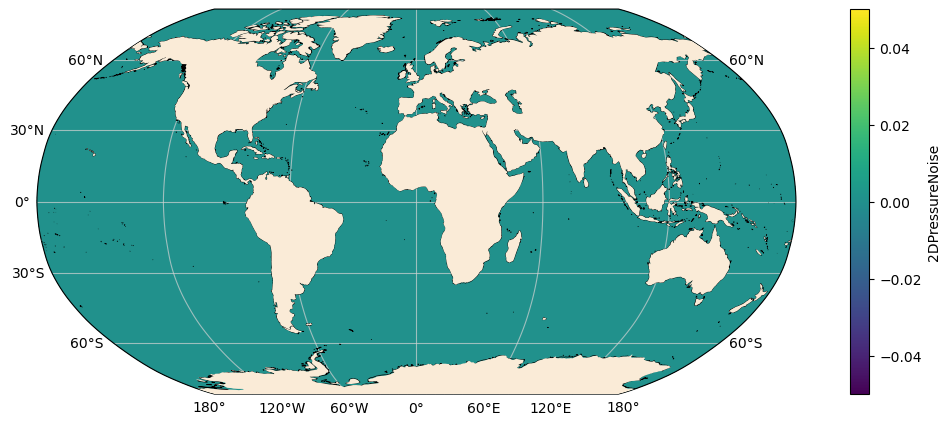

In [4]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=Plotter.figsize_map,
    subplot_kw=dict(projection=Plotter.display_projection),
)
ax.coastlines(
    resolution=Plotter.coast_resolution, linewidth=Plotter.coast_width, zorder=10
)
nc = xr.load_dataset(
    "/home/mverlaan/einf220/fromDavid/saved_results/gtsm/kg_36stations_loc/kgStorage_201406030000/kalmanGainStorage.nc"
)
nc["2DPressureNoise_dimension_0"] = nc["2DPressureNoise_dimension_0"] - 90
nc["2DPressureNoise_dimension_1"] = nc["2DPressureNoise_dimension_1"] - 180

# data = nc["2DPressureNoise"].isel(station_dimension=0)
data = nc["2DPressureNoise"].max(dim="station_dimension")
data.plot(ax=ax, transform=Plotter.orig_projection)

ax.add_feature(cf.LAND, facecolor=Plotter.land_color, zorder=10)
Plotter.map_grid(ax)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.savefig(Plotter.add_folder("kg.png"), bbox_inches="tight")

In [ ]:
nc["2DPressureNoise_dimension_0"] = nc["2DPressureNoise_dimension_0"] - 90

<Figure size 640x480 with 0 Axes>

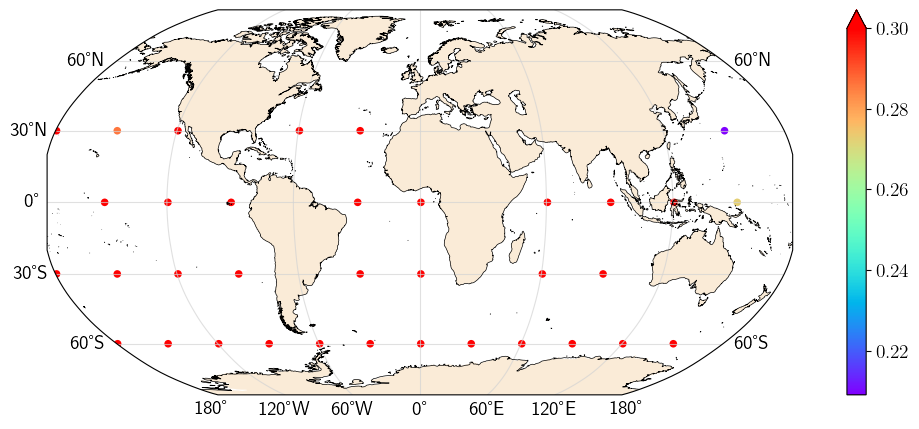

<Figure size 640x480 with 0 Axes>

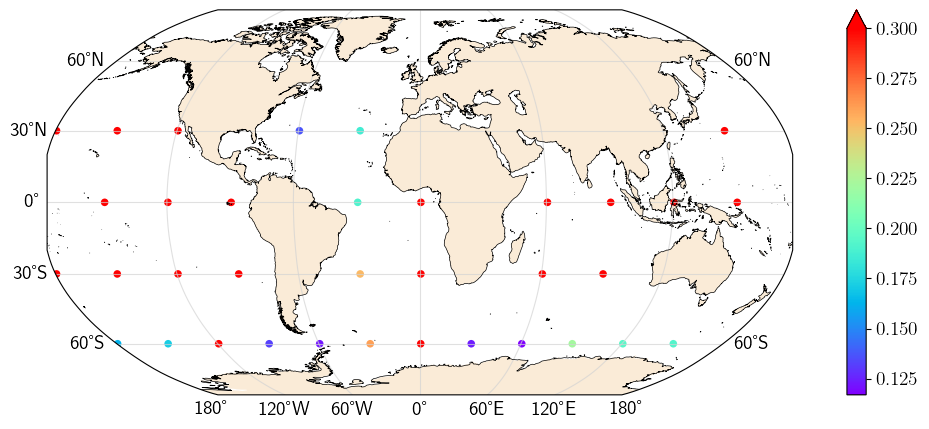

<Figure size 640x480 with 0 Axes>

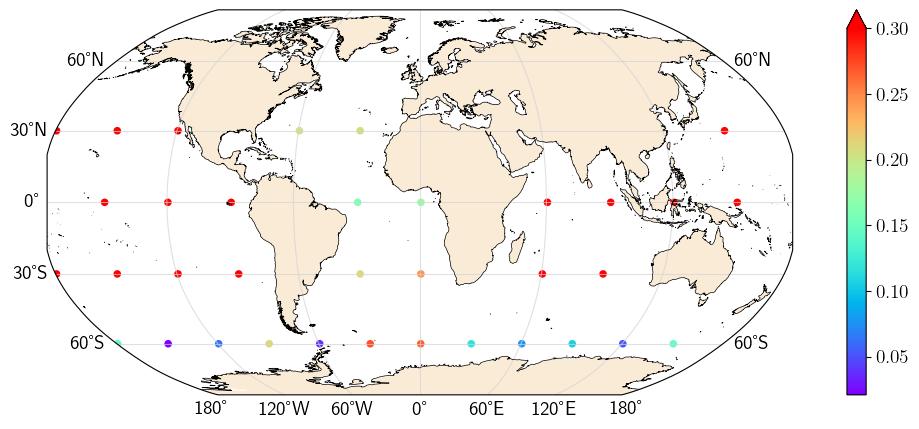

In [22]:
for rmses, label in zip(rmses_per_exp, labels):
    Plotter.plot_map(
        xs_locs,
        ys_locs,
        rmses,
        size=30,
        zorder_land=-1,
        cmap="rainbow",
        path=f"rmses_{label}.png",
        vmax=0.3,
        extent=(-180, 180, -90, 90),
    )
    plt.show()